## Zindi Tech4MentalHealth

https://zindi.africa/competitions/basic-needs-basic-rights-kenya-tech4mentalhealth/data

In [1]:
# отключение ворнингов
import warnings
warnings.filterwarnings('ignore')

import collections
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, log_loss
from scipy.sparse import csr_matrix, hstack

In [2]:
# отображение столбцов в пандас
pd.set_option('display.max_columns', 100)

# настройка размеров графиков
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)

# настройка стиля графиков
plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


In [3]:
# читаем данные

df = pd.read_csv(os.path.join('data', 'Train.csv'))

# выведу 5 записей для проверки
df.head(5)

,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression
3,6UY7DX6Q,Why is life important?,Suicide
4,FYC0FTFB,How could I be helped to go through the depres...,Depression


## Подготовка данных

In [4]:
# закодирую целевую переменную

num_targets = df['label'].nunique()

targets_encoder = dict(zip(df['label'].unique(), range(num_targets)))
df['label'] = df['label'].map(targets_encoder)

In [5]:
# разобью на трейн и валидацию

X = df['text']
y = df['label']

# воспроизводимость
rs = np.random.seed(0)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,
                                                      random_state=rs, stratify=y)

In [6]:
# токенизация текста

token_re = re.compile(r'[\w\d]+')

def tokenize_text_simple_regex(txt, regex=r'[\w\d]+', min_token_size=5):
    """
    Tokenize single text
    :param txt: text
    :param regex: regular expression pattern
    :param min_token_size: 
    """
    txt = txt.lower()
    token_re = re.compile(regex)
    all_tokens = token_re.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]


def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
    """
    Tokenize corpus of texts
    :param texts: array of texts
    :param tokenizer: tokenizer function
    """
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]


def lists_to_text_array(texts):
    """
    Transforms array of tokens to array of texts
    :param texts: array of texts
    """
    return np.array([' '.join(text) for text in texts])

In [7]:
# токенизируем
train_tokenized = tokenize_corpus(X_train.values)
test_tokenized = tokenize_corpus(X_valid.values)

# возвращаемся к массиву текстов
train_tokenized = lists_to_text_array(train_tokenized)
test_tokenized = lists_to_text_array(test_tokenized)

## Bag of Words

In [8]:
# импорт библиотек

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier

In [9]:
# преобразую в bag of words вектора
vectorizer = CountVectorizer()

train_sparse = vectorizer.fit_transform(train_tokenized)
test_sparse = vectorizer.transform(test_tokenized)

## Обучение моделей

In [10]:
def cross_validation(classifier, X_train, y_train, cv=3, scoring='accuracy'):
    """
    Cross-validation for classification problem
    :param classifier: sklearn-compatible classifier
    :param X_train: matrix of features
    :param y_train: array of labels
    :param cv: number of cross-validation splits
    :param scoring: evaluation parameter
    """
    
    # название модели для красивого вывода
    clf_name = str(classifier)
    try:
        clf_name = clf_name[:clf_name.index('(')]
    except ValueError:
        pass
    cv_scores = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv)
    mean_score = np.abs(np.mean(cv_scores))
    print(f'Среднее значение \033[1m{scoring}\033[0m для {clf_name} на валидации: \033[1m{mean_score:.4f}\033[0m')
    
    
def fit_evaluate(classifier, X_train, X_test, y_train, y_test,
                 multiclass=False,
                 metric=accuracy_score):
    """
    Fits classifier on train data, evaluates on test
    :param classifier: sklearn-compatible classifier
    :param X_train: matrix of train features
    :param y_train: array of train labels
    :param X_test: matrix of test features
    :param y_test: array of test labels
    :param metric: sklearn-compatible metric function
    """
    
    # название модели для красивого вывода
    clf_name = str(classifier)
    try:
        clf_name = clf_name[:clf_name.index('(')]
    except ValueError:
        pass
    
    # название метрики 
    metric_name = str(metric)
    metric_name = metric_name[metric_name.index(' ')+1:metric_name.index(' at')]
    classifier.fit(X_train, y_train)
    if multiclass:
        predictions = classifier.predict_proba(X_test)
    else:
        predictions = classifier.predict_proba(X_test)[:, 1]
    print('Среднее значение \033[1m{}\033[0m для {} на отложенной выборке: \033[1m{:.4f}\033[0m'.format(
        metric_name, clf_name, metric(y_test, predictions)))

In [11]:
# логистическая регрессия
logit = LogisticRegression(solver='lbfgs',random_state=rs, n_jobs=-1)

# кросс-валидация
cross_validation(logit, train_sparse, y_train, cv=5, scoring='neg_log_loss')

# отложенная выборка
fit_evaluate(logit, train_sparse, test_sparse, y_train , y_valid, multiclass=True, metric=log_loss)

Среднее значение neg_log_loss для LogisticRegression на валидации: 0.6040
Среднее значение log_loss для LogisticRegression на отложенной выборке: 0.5857


In [12]:
# бустинг
lgbm = LGBMClassifier(random_state=rs, n_jobs=-1)

# кросс-валидация
cross_validation(lgbm, train_sparse.toarray(), y_train, cv=5, scoring='neg_log_loss')

# отложенная выборка
fit_evaluate(lgbm, train_sparse.toarray(), test_sparse.toarray(),
             y_train , y_valid, multiclass=True, metric=log_loss)

Среднее значение neg_log_loss для LGBMClassifier на валидации: 0.8474
Среднее значение log_loss для LGBMClassifier на отложенной выборке: 0.8196


Логрег выглядит лучше всех без n-грамм

## TF-IDF

In [13]:
# преобразую в tf-idf вектора с n-граммами
tfid_vec = TfidfVectorizer(ngram_range=(1, 3), max_features=50000)

train_tfid = tfid_vec.fit_transform(train_tokenized)
test_tfid = tfid_vec.transform(test_tokenized)

In [14]:
# логистическая регрессия
logit = LogisticRegression(solver='lbfgs',random_state=17, n_jobs=-1)

# кросс-валидация
cross_validation(logit, train_tfid, y_train, cv=5, scoring='neg_log_loss')

# отложенная выборка
fit_evaluate(logit, train_tfid, test_tfid, y_train , y_valid, multiclass=True, metric=log_loss)

Среднее значение neg_log_loss для LogisticRegression на валидации: 0.7835
Среднее значение log_loss для LogisticRegression на отложенной выборке: 0.6818


In [15]:
# бустинг
lgbm = LGBMClassifier(random_state=17, n_jobs=-1)

# кросс-валидация
cross_validation(lgbm, train_tfid, y_train, cv=5, scoring='neg_log_loss')

# отложенная выборка
fit_evaluate(lgbm, train_tfid, test_tfid,
             y_train , y_valid, multiclass=True, metric=log_loss)

Среднее значение neg_log_loss для LGBMClassifier на валидации: 0.8474
Среднее значение log_loss для LGBMClassifier на отложенной выборке: 0.8196


C n-граммами и tf-idf стало хуже.

In [16]:
# доля верных ответов логрега c BoW

logit.fit(train_sparse, y_train)
preds = logit.predict_proba(test_sparse)
pred_labes = [i.argmax(axis=0) for i in preds]

print(f'Доля верных ответов {accuracy_score(y_valid, pred_labes):.4f}')

Доля верных ответов 0.8145


## Feature engineering

Добавлю метапризнаки:
- кол-во символов
- кол-во слов
- кол-во символов в верхнем регистре 
- кол-во знаков препинания

In [17]:
# считаем все символы, кроме пробелов
df['letters_cnt'] = df['text'].apply(lambda x: len(re.findall(r'[\S]', x)))

# считаем кол-во слов 
df['words_cnt'] = df['text'].apply(lambda x: len(re.findall(r'[\w\d]+', x)))

# считаем кол-во слов в верхнем регистре 
df['uppercase_cnt'] = df['text'].apply(lambda x: len(re.findall(r'[A-Z]+', x)))

# считаем кол-во знаков препинания 
df['punctuation_cnt'] = df['text'].apply(lambda x: len(re.findall(r'[-.?!)(,:]', x)))

df.tail(5)

,ID,text,label,letters_cnt,words_cnt,uppercase_cnt,punctuation_cnt
611,BOHSNXCN,What should I do to stop alcoholism?,3,30,7,2,1
612,GVDXRQPY,How to become my oldself again,2,25,6,1,0
613,IO4JHIQS,How can someone stop it?,3,20,5,1,1
614,1DS3P1XO,I feel unworthy,0,13,3,1,0
615,ORF71PVQ,I feel so discouraged with life,0,26,6,1,0


In [18]:
def dist_plot(df, feature, target):
    """
    Строит график плотности распределения по каждому из значений
    целевой переменной (до 8 значений)
    """
    
    matplotlib_colors = ['g', 'r', 'b', 'c', 'm', 'y', 'k', 'w']
    plt_colors = dict(zip(range(len(matplotlib_colors)), matplotlib_colors))
    
    for idx, value in enumerate(df[target].unique()):
        sns.kdeplot(df[df[target] == value][feature], label=value, color=plt_colors[idx])
    
    plt.title('Распределение {}'.format(feature))
    plt.show()

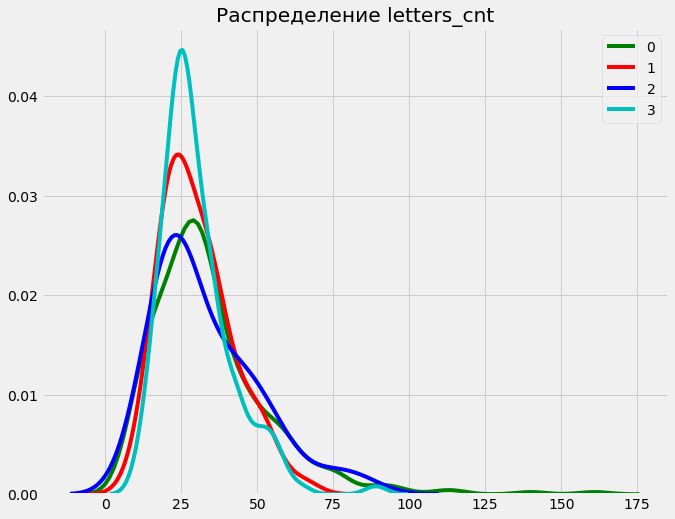

In [19]:
dist_plot(df, 'letters_cnt', 'label')

Не похоже что по этому признаку можно хорошо разделить тексты, но пока оставлю.

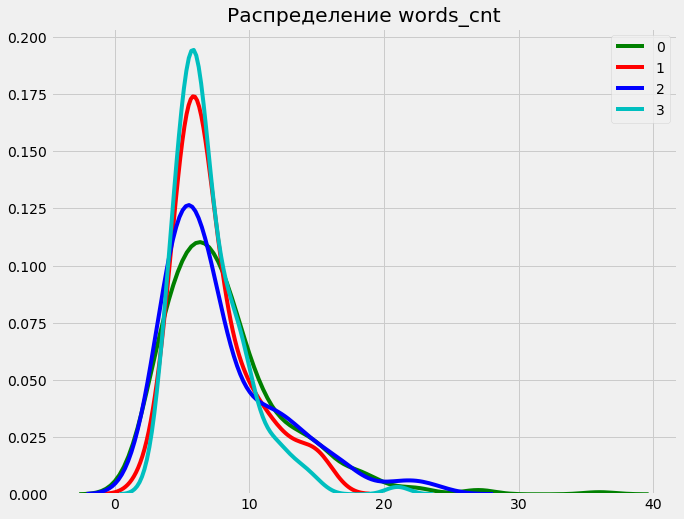

In [20]:
dist_plot(df, 'words_cnt', 'label')

Здесь ситуация схожая.

In [21]:
def feature_stat(data, feature, target, ylim=None):
    """
    Выводит гистограмму и среднее значение целевой
    по группе.
    Подходит для категориальных переменных
    """
    
    # выводим долю таргета по каждой группе
    print('\033[1m{} stats: \033[0m'.format(feature))
    print()
    for value in sort(df[feature].unique()):
        print('Mean target in group {}: {:.4f}'.format(value, df[df[feature]==value][target].mean()))
        
    x = [i for i in data.groupby(feature)[target].count().index]
    y_cnt = [i for i in data.groupby(feature)[target].count().values]
    y_mean = [i for i in data.groupby(feature)[target].mean().values]
    ind = np.arange(len(data[feature].unique()))
    
    fig, ax1 = plt.subplots()
    ax1.bar(ind, y_cnt, align='center', color='royalblue', width=0.4, alpha=0.8)
    ax1.set_xlabel(feature)
    ax1.set_ylabel('count', color='b',)
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    ax2.plot(ind, y_mean, marker= 'o', linestyle='-', color='r', linewidth=5)
    ax2.set_ylabel(f'{target} mean rate', color='r')
    ax2.tick_params('y', colors='r')
    plt.xticks(ind, x)
    ax1.set_xticklabels(x, fontsize=14)
    
    if ylim:
        ax2.set_ylim(ylim)
        
    plt.title(f'{feature} and {target}', fontsize=20)
    plt.grid(False)
    plt.show()

label stats: 

Mean target in group 0: 1.3352
Mean target in group 1: 1.1034
Mean target in group 2: 1.1818
Mean target in group 3: 1.2357


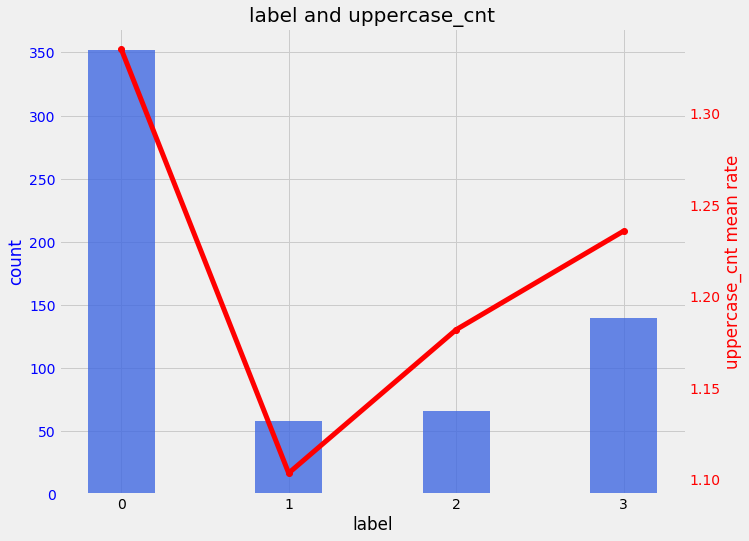

In [22]:
feature_stat(df, 'label', 'uppercase_cnt')

label stats: 

Mean target in group 0: 0.4205
Mean target in group 1: 0.9138
Mean target in group 2: 0.4545
Mean target in group 3: 0.5429


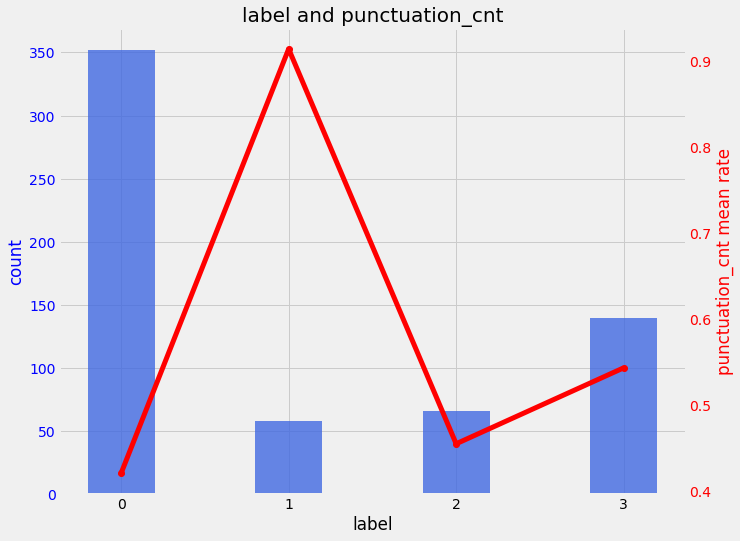

In [23]:
feature_stat(df, 'label', 'punctuation_cnt')

## Характерные слова

Есть также идея поисследовать наиболее частотные и, наоборот, редкие слова в каждой группе.

In [24]:
def build_vocabulary(tokenized_texts, min_count=5):
    """
    Builds vocabulary 
    :param tokenized_texts: array of tokens
    :min_count: minimum count for specific token
    """
    
    word_counts = collections.defaultdict(int)
    
    for txt in tokenized_texts:
        for token in txt:
            word_counts[token] += 1
    
    # убрать слишком редкие слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count}
    
    # отсортировать по убыванию
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])
    
    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}
    
    return word2id

In [25]:
print(targets_encoder)

{'Depression': 0, 'Drugs': 1, 'Suicide': 2, 'Alcohol': 3}


In [26]:
# Depression
depression = tokenize_corpus(df[df['label'] == 0]['text'], min_token_size=5)

depression_dict = build_vocabulary(depression, min_count=1)

# выведу 10 самых популярных и сохраню в список
depression_top10 = list()

for key, value in depression_dict.items():
    if value <= 10:
        depression_top10.append(key)
        print(key)

depression
depressed
feeling
better
lonely
alone
myself
overcome
world
issues
could


In [27]:
# Drugs
drugs = tokenize_corpus(df[df['label'] == 1]['text'], min_token_size=5)

drugs_dict = build_vocabulary(drugs, min_count=1)

# выведу 10 самых популярных и сохраню в список
drugs_top10 = list()

for key, value in drugs_dict.items():
    if value <= 10:
        drugs_top10.append(key)
        print(key)

bhang
effects
smoking
taking
smoke
avoid
drugs
hallucinations
addiction
could
using


In [28]:
# Suicide
suicide = tokenize_corpus(df[df['label'] == 2]['text'], min_token_size=5)

suicide_dict = build_vocabulary(suicide, min_count=1)

# выведу 10 самых популярных и сохраню в список
suicide_top10 = list()

for key, value in suicide_dict.items():
    if value <= 10:
        suicide_top10.append(key)
        print(key)

suicide
overcome
thoughts
causes
suicidal
sought
assistance
people
commiting
avoid
again


In [29]:
# Alcohol

alcohol = tokenize_corpus(df[df['label'] == 3]['text'], min_token_size=5)

alcohol_dict = build_vocabulary(alcohol, min_count=1)

# выведу 10 самых популярных и сохраню в список
alcohol_top10 = list()

for key, value in alcohol_dict.items():
    if value <= 10:
        alcohol_top10.append(key)
        print(key)

alcohol
taking
alcoholism
avoid
drinking
effects
using
addiction
overcome
should
drink


Кажется, что проверять вхождение этих слов в текст неплохая идея.  
Вероятно, для улучшения результата нужно будет прикрутить стемминг или лемматизацию.

In [30]:
# избавлюсь от общих частотных слов 

depression_top10 = [token for token in depression_top10
                    if token not in drugs_top10+suicide_top10+alcohol_top10]

drugs_top10 = [token for token in drugs_top10
                    if token not in depression_top10+suicide_top10+alcohol_top10]

suicide_top10 = [token for token in suicide_top10
                    if token not in depression_top10+drugs_top10+alcohol_top10]

alcohol_top10 = [token for token in alcohol_top10
                    if token not in depression_top10+drugs_top10+suicide_top10]

In [31]:
# для удобства добавлю series со списком токенов

df['text_tokenized'] = df['text'].apply(tokenize_text_simple_regex)
df['depression_top'] = df['text_tokenized'].apply(lambda x:
                                                  len([i for i in x if i in depression_top10]))
df['drugs_top'] = df['text_tokenized'].apply(lambda x:
                                                  len([i for i in x if i in drugs_top10]))
df['suicide_top'] = df['text_tokenized'].apply(lambda x:
                                                  len([i for i in x if i in suicide_top10]))
df['alcohol_top'] = df['text_tokenized'].apply(lambda x:
                                                  len([i for i in x if i in alcohol_top10]))

df.drop('text_tokenized', axis=1, inplace=True)

In [32]:
df.head()

,ID,text,label,letters_cnt,words_cnt,uppercase_cnt,punctuation_cnt,depression_top,drugs_top,suicide_top,alcohol_top
0,SUAVK39Z,I feel that it was better I dieAm happy,0,31,9,3,0,1,0,0,0
1,9JDAGUV3,Why do I get hallucinations?,1,24,5,2,1,0,1,0,0
2,419WR1LQ,I am stresseed due to lack of financial suppor...,0,47,11,1,0,0,0,0,0
3,6UY7DX6Q,Why is life important?,2,19,4,1,1,0,0,0,0
4,FYC0FTFB,How could I be helped to go through the depres...,0,42,10,2,1,1,1,0,0


## Построение моделей

In [33]:
# CountVectorizer + новые фичи

# разобью на трейн и валидацию
X = df.drop(['ID', 'label'], axis=1)
y = df['label']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=rs, stratify=y)

# формируем sparse-матрицу текстов
vectorizer = CountVectorizer(tokenizer=tokenize_text_simple_regex)

train_texts_vec = vectorizer.fit_transform(X_train['text'].values)
valid_texts_vec = vectorizer.transform(X_valid['text'].values)

In [34]:
# стандартизация данных

scaler = StandardScaler()
scaler.fit(X_train.drop('text', axis=1).values) # .reshape(-1, 1)

X_train = scaler.transform(X_train.drop('text', axis=1).values)
X_valid = scaler.transform(X_valid.drop('text', axis=1).values)

In [35]:
# объединение с BoW

X_train = csr_matrix(hstack([train_texts_vec.toarray(), X_train]))
X_valid = csr_matrix(hstack([valid_texts_vec.toarray(), X_valid]))

In [36]:
# логистическая регрессия

cross_validation(logit, X_train, y_train, cv=5, scoring='neg_log_loss')
fit_evaluate(logit, X_train, X_valid, y_train, y_valid,  multiclass=True, metric=log_loss)

Среднее значение neg_log_loss для LogisticRegression на валидации: 0.5323
Среднее значение log_loss для LogisticRegression на отложенной выборке: 0.5452


In [37]:
# бустинг 

cross_validation(lgbm, X_train, y_train, cv=5, scoring='neg_log_loss')
fit_evaluate(lgbm, X_train, X_valid, y_train, y_valid,  multiclass=True, metric=log_loss)

Среднее значение neg_log_loss для LGBMClassifier на валидации: 0.6645
Среднее значение log_loss для LGBMClassifier на отложенной выборке: 0.6975


Результат улучшился, особенно у логистической регрессии.

In [38]:
# доля верных ответов логрега c BoW и новыми фичами

logit.fit(X_train, y_train)
preds = logit.predict_proba(X_valid)
pred_labes = [i.argmax(axis=0) for i in preds]

print(f'Доля верных ответов {accuracy_score(y_valid, pred_labes):.4f}')

Доля верных ответов 0.8145


## Подбор гиперпараметров

In [39]:
# импорт библиотек

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [40]:
def score(params):
    solver=params['solver']['solver']
    penalty=params['solver']['penalty']
    logit=LogisticRegression(penalty=penalty, C=params['C'],
                           solver=solver, tol=params['tol'],
                           l1_ratio=params['l1_ratio'], max_iter=500)
    logit.fit(X_train, y_train)
    predictions = logit.predict_proba(X_valid)
    score = log_loss(y_valid, predictions)
    return {'loss': score, 'status': STATUS_OK}

In [41]:
def optimize(trials):
    space = {
        'C': hp.loguniform('x_C', -10, 1),
        'solver':  hp.choice('x_solver',[{'solver':'newton-cg', 'penalty': hp.choice('p_newton',['none','l2'])},
                                         {'solver':'lbfgs', 'penalty': hp.choice('p_lbfgs',['none','l2'])},
                                         {'solver': 'liblinear', 'penalty': hp.choice('p_lib',['l1','l2'])}, 
                                         {'solver': 'sag', 'penalty': hp.choice('p_sag',['l2','none'])}, 
                                         {'solver':'saga', 'penalty':'elasticnet'}]),
       'tol': hp.loguniform('x_tol', -13, -1),
       'l1_ratio': hp.uniform('x_l1', 0, 1)
        }
   
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=100)
    return best

In [42]:
trials = Trials()
best_params = optimize(trials)
best_params

100%|██████████| 100/100 [00:11<00:00,  8.49trial/s, best loss: 0.5432917051593972]


{'p_sag': 0,
 'x_C': 1.2107683679560208,
 'x_l1': 0.6461413199969754,
 'x_solver': 3,
 'x_tol': 0.00022378128287848237}

In [43]:
logit = LogisticRegression(C=best_params['x_C'], solver='newton-cg', penalty='l2',
                           l1_ratio=best_params['x_l1'], tol=best_params['x_tol'],
                           max_iter=500
                          )

logit.fit(X_train, y_train)
preds = logit.predict_proba(X_valid)
log_loss(y_valid, preds)

0.5447300528352471

In [44]:
# доля верных ответов логрега c BoW и новыми фичами и гиперпараметрами

pred_labes = [i.argmax(axis=0) for i in preds]

print(f'Доля верных ответов {accuracy_score(y_valid, pred_labes):.4f}')

Доля верных ответов 0.8145
